# Analysis

Analysis for the OB-19 symposium paper:

**Identification of occupancy patterns using opportunistic in-situ measurements in Smart Homes**

**Steven Firth and Ben Halls**

Presented at OB-19: 5th International Symposium on Occupant Behaviour, San Antonio, US, 13 March 2019


## Set up

### Import modules

In [108]:
%matplotlib inline
import config
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import os

### Parse xml

This uses the filepath given in the config.py file to parse the REFIT xml file.

In [2]:
from lxml import etree
tree=etree.parse(config.refit_building_survey)
NS={'a':'http://www.refitsmarthomes.org'}
tree

### Parse csv

This uses the filepath given in the config.py file to parse the REFIT csv file.

In [114]:
csv=pd.read_csv(config.refit_time_series_values)
csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25312397 entries, 0 to 25312396
Data columns (total 3 columns):
TimeSeriesVariable/@id    object
dateTime                  object
data                      float64
dtypes: float64(1), object(2)
memory usage: 579.4+ MB


In [4]:
csv.head()

,TimeSeriesVariable/@id,dateTime,data
0,TimeSeriesVariable1,2013-10-02T05:00:00Z,17.772
1,TimeSeriesVariable1,2013-10-02T05:30:00Z,18.081
2,TimeSeriesVariable1,2013-10-02T06:00:00Z,18.176
3,TimeSeriesVariable1,2013-10-02T06:30:00Z,18.176
4,TimeSeriesVariable1,2013-10-02T07:00:00Z,18.105


## Figure 1 - Motion detection for Building 1 on 7th Jan 2015

### Find the Space elements in Building 1

In [91]:
spaces=tree.xpath('/a:RefitXML/a:Stock/a:Building[@id="Building01"]/a:Space',namespaces=NS)
spaces=spaces[:-1] #remove the 'wall' space as it's not room in the building
print('number of spaces',len(spaces))
print([space.get('roomType') for space in spaces])

number of spaces 19
['Study', 'Hallway', 'Stairs', 'Cloakroom', 'WC', 'Kitchen', 'Utility room', 'Conservatory', 'Living room', 'Bedroom', 'Stairs', 'Landing', 'Bathroom', 'Bedroom', 'Bedroom', 'Ensuite', 'Bedroom', 'Hot water tank', 'Loft']


### Find the TimeSeriesVariable elements of the spaces

These are stored in a dictionary with {space_element,[timeseriesvariable_element]}

In [97]:
st='.//a:TimeSeriesVariable[@variableType="Motion"]'
d={s:s.xpath(st,namespaces=NS) for s in spaces}
[(s.get('roomType'),[tsv.get('id') for tsv in tsvs]) for s,tsvs in d.items()]

[('Study', []),
 ('Hallway', ['TimeSeriesVariable2193']),
 ('Stairs', []),
 ('Cloakroom', []),
 ('WC', []),
 ('Kitchen', ['TimeSeriesVariable2190']),
 ('Utility room', ['TimeSeriesVariable2097']),
 ('Conservatory', ['TimeSeriesVariable2191']),
 ('Living room', ['TimeSeriesVariable2192']),
 ('Bedroom', []),
 ('Stairs', []),
 ('Landing', []),
 ('Bathroom', []),
 ('Bedroom', []),
 ('Bedroom', []),
 ('Ensuite', []),
 ('Bedroom', []),
 ('Hot water tank', []),
 ('Loft', [])]

### Get all tsv ids

In [100]:
tsvs=[]
for x in d.values(): tsvs+=x
tsv_ids=[tsv.get('id') for tsv in tsvs]
print(tsv_ids)

['TimeSeriesVariable2193', 'TimeSeriesVariable2190', 'TimeSeriesVariable2097', 'TimeSeriesVariable2191', 'TimeSeriesVariable2192']


### Filter csv data

Creates a new DataFrame 'df' which is the csv data filtered by the motion tsv ids and for 7th January 2015 only. Places the datetime column as the index of this new dataframe and converts all motion detection data values to 1.

In [103]:
df=csv[csv['TimeSeriesVariable/@id'].isin(tsv_ids)].copy()
df['dateTime']=pd.to_datetime(df['dateTime'])
df=df.set_index('dateTime')
df=df[df.index>pd.Timestamp('2015-01-07')]
df=df[df.index<pd.Timestamp('2015-01-08')]
df.loc[df['data'].isin([-10003,-10004]),'data']=1
print('length of new dataframe',len(df))
df.head()

length of new dataframe 305


,TimeSeriesVariable/@id,data
dateTime,,
2015-01-07 08:04:00,TimeSeriesVariable2097,1.0
2015-01-07 08:05:00,TimeSeriesVariable2097,1.0
2015-01-07 08:05:00,TimeSeriesVariable2097,1.0
2015-01-07 08:06:00,TimeSeriesVariable2097,1.0
2015-01-07 08:09:00,TimeSeriesVariable2097,1.0


## Plot figure

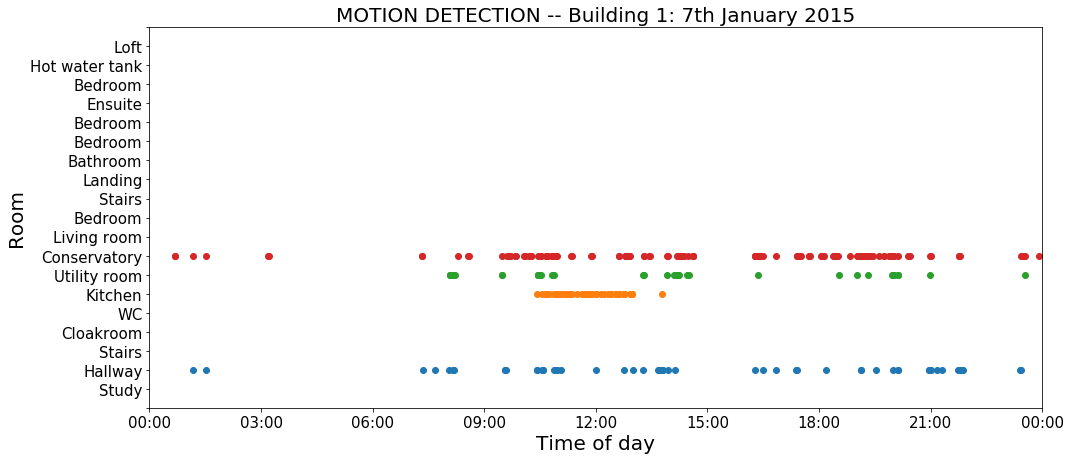

In [148]:
def plot_motion_data():
    for i,(s,tsv) in enumerate(d.items()):
        if tsv:
            df1=df[df['TimeSeriesVariable/@id']==tsv[0].get('id')].copy()
            df1['data']=i
            ax.plot(df1['data'],'o')
    #title
    ax.set_title('MOTION DETECTION -- Building 1: 7th January 2015', fontsize=20)
    #x-axis
    ax.set_xlabel('Time of day',fontsize=20)
    ax.set_xlim(pd.Timestamp('2015-01-07'),pd.Timestamp('2015-01-08'))
    myFmt = mdates.DateFormatter('%H:%M')
    ax.xaxis.set_major_formatter(myFmt)
    ax.tick_params(axis='x', labelsize=15)
    #y-axis
    ax.set_ylabel('Room',fontsize=20)
    ax.set_ylim(0,18)
    ax.set_yticks(range(-1,20))
    ax.set_yticklabels(['']+[space.get('roomType') for space in spaces]+[''],fontsize=15)    
fig, ax = plt.subplots(figsize=(16, 7))  
plot_motion_data()
fig.savefig('Figure_1.png',bbox_inches='tight', pad_inches=0.25)
plt.show()

## Figure 2 - Motion detection and Smart Meter data for Building 1 on 7th Jan 2015

## Get electricity data for building 1

In [112]:
csv_elec=pd.read_csv(os.path.join(config.refit_electrical_measurements_folder,'House_1.csv'))
csv_elec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6960008 entries, 0 to 6960007
Data columns (total 12 columns):
Time          object
Unix          int64
Aggregate     int64
Appliance1    int64
Appliance2    int64
Appliance3    int64
Appliance4    int64
Appliance5    int64
Appliance6    int64
Appliance7    int64
Appliance8    int64
Appliance9    int64
dtypes: int64(11), object(1)
memory usage: 637.2+ MB


In [113]:
csv_elec.head()

,Time,Unix,Aggregate,Appliance1,Appliance2,Appliance3,Appliance4,Appliance5,Appliance6,Appliance7,Appliance8,Appliance9
0,2013-10-09 13:06:17,1381323977,523,74,0,69,0,0,0,0,0,1
1,2013-10-09 13:06:31,1381323991,526,75,0,69,0,0,0,0,0,1
2,2013-10-09 13:06:46,1381324006,540,74,0,68,0,0,0,0,0,1
3,2013-10-09 13:07:01,1381324021,532,74,0,68,0,0,0,0,0,1
4,2013-10-09 13:07:15,1381324035,540,74,0,69,0,0,0,0,0,1


### Filter electricity data

Creates a new DataFrame 'df' which is the csv data filtered by the motion tsv ids and for 7th January 2015 only. Places the datetime column as the index of this new dataframe and converts all motion detection data values to 1.

In [122]:
df_elec=csv_elec[['Time','Aggregate']].copy()
df_elec['Time']=pd.to_datetime(df_elec['Time'])
df_elec=df_elec.set_index('Time')
df_elec=df_elec[df_elec.index>pd.Timestamp('2015-01-07')]
df_elec=df_elec[df_elec.index<pd.Timestamp('2015-01-08')]
print('length of new dataframe',len(df_elec))
df_elec.head()

length of new dataframe 12593


,Aggregate
Time,
2015-01-07 00:00:03,342
2015-01-07 00:00:10,348
2015-01-07 00:00:16,347
2015-01-07 00:00:23,317
2015-01-07 00:00:30,322


## Plot figure

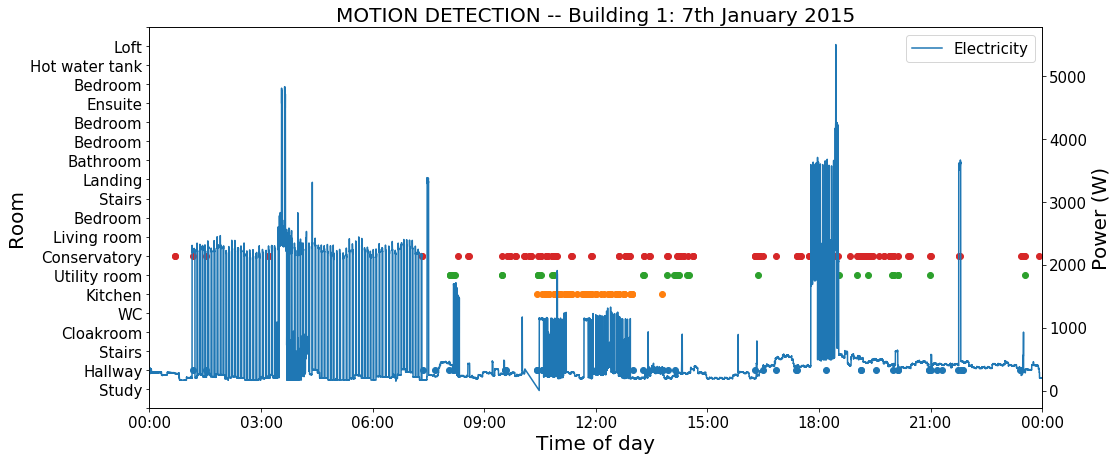

In [149]:
fig, ax = plt.subplots(figsize=(16, 7))  
plot_motion_data()
ax2 = ax.twinx()
ax2.plot(df_elec['Aggregate'],label='Electricity')
ax2.set_ylabel('Power (W)',fontsize=20)
ax2.tick_params(axis='y', labelsize=15)
ax2.legend(fontsize=15)
ax2.set_xlim(pd.Timestamp('2015-01-07'),pd.Timestamp('2015-01-08'))
myFmt = mdates.DateFormatter('%H:%M')
ax2.xaxis.set_major_formatter(myFmt)
fig.savefig('Figure_2.png',bbox_inches='tight', pad_inches=0.25)
plt.show()